# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Итоговый-вывод" data-toc-modified-id="Итоговый-вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Итоговый вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

В данных имеются следующие входные признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

А также целевой признак:
- Price — цена (евро)

In [1]:
import sklearn # Проверка версии sklearn. Обновляем при необходимости
if sklearn.__version__[0] == '0':
    !pip install scikit-learn -U # После установки надо перезапустить ядро
sklearn.__version__ 

'1.5.1'

In [2]:
#!pip install -U Pillow # Для решения ошибки с профайлером(беда с версиями)

In [3]:
import pandas as pd
import numpy as np

try:
    from ydata_profiling import ProfileReport
except:
    !pip install -U Pillow # Для решения ошибки с профайлером
    !pip install -U ydata-profiling
    from ydata_profiling import ProfileReport

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, make_scorer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
RANDOM_STATE = 42

## Подготовка данных

Для начала проведём EDA - разведочный анализ данных. Взглянем на них под всеми возможными углами, посмотрим на имеющиеся аномалии, корреляцию признаков и проверим общее качество имеющихся данных.

In [5]:
try:
    ds = pd.read_csv('/datasets/autos.csv')
except:
    ds = pd.read_csv('datasets/autos.csv')
ds.info()
ProfileReport(ds)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Пройдёмся по порядку. Профайлер любезно сгруппировал для нас все проблемы данных, на которые нам стоит взглянуть.

Начнём с пропусков. У нас очень много данных, но пропусков в них также много. Если мы будем заполнять пропуски во всех признаках - это будет скорее подделка данных, чем их исправление. Поэтому оставим только записи без пропусков, благо количество данных это сделать позволяет. Единственное исключение сделаем для признака `Repaired`, который содержит больше всего пропусков. Все пропуски в нём заменим на самое часто встречаемое значение. Так мы спасём около 35 тысяч записей.

In [6]:
ds['Repaired'] = ds['Repaired'].fillna('no')
ds = ds.dropna()
ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 284126 entries, 2 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        284126 non-null  object
 1   Price              284126 non-null  int64 
 2   VehicleType        284126 non-null  object
 3   RegistrationYear   284126 non-null  int64 
 4   Gearbox            284126 non-null  object
 5   Power              284126 non-null  int64 
 6   Model              284126 non-null  object
 7   Kilometer          284126 non-null  int64 
 8   RegistrationMonth  284126 non-null  int64 
 9   FuelType           284126 non-null  object
 10  Brand              284126 non-null  object
 11  Repaired           284126 non-null  object
 12  DateCreated        284126 non-null  object
 13  NumberOfPictures   284126 non-null  int64 
 14  PostalCode         284126 non-null  int64 
 15  LastSeen           284126 non-null  object
dtypes: int64(7), object(9)
me

Лучше меньше данных, зато качественных.

`NumberOfPictures` - константа, содержащая исключительно нули. Судя по всему, признак сломан. Сомневаюсь, что за 350 тысяч выставленных на продажу автомобилей не было сделано ни одного фото. От него можно избавиться

In [7]:
ds = ds.drop('NumberOfPictures', axis=1)
ds.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'PostalCode', 'LastSeen'],
      dtype='object')

Аномальные значения года регистрации. От 1000 до 9999

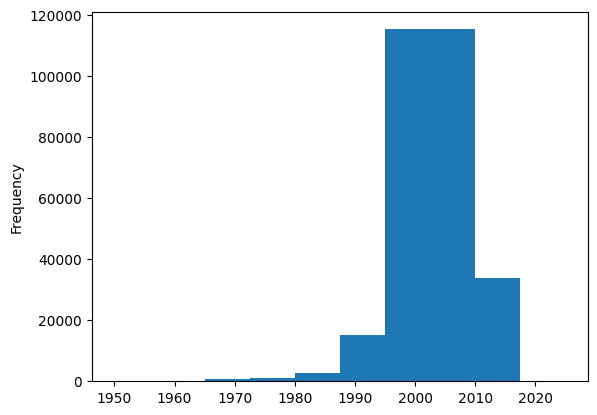

In [8]:
ds['RegistrationYear'].plot(kind='hist', range=(1950, 2025));

Основная масса значений находится в промежутке от 1950 до 2025, её мы и возьмём.

In [9]:
ds = ds[ds['RegistrationYear'].isin(range(1950, 2025))]
print('max:', ds['RegistrationYear'].max())
print('min:', ds['RegistrationYear'].min())

max: 2018
min: 1950


`Power`, значение мощности в лошадиных силах, содержит аномально высокие значения. Исключим все записи со значениями выше, чем среднее плюс 3 стандартных отклонения.

In [10]:
ds = ds[ds['Power']<=ds['Power'].mean()+np.std(ds['Power'])*3]
ds['Power'].max()

620

Оно-же содержит огромное количество нулей, около 11%. Однако, учитывая специфику магазина, можно предположить, что таким образом отображаются машины не на ходу. Оставим эти значения.

Все даты сохранились в формате строк. Переведём их в формат даты для удобства вычислений.

In [11]:
for i in ['DateCrawled', 'DateCreated', 'LastSeen']:
    ds[i] = pd.to_datetime(ds[i], format='%Y-%m-%d %H:%M:%S')
    print(np.dtype(ds[i]))

datetime64[ns]
datetime64[ns]
datetime64[ns]


У нас имеется дата создания анкеты, и дата последней активности пользователя. Вычтем одно из другого, и получим количество дней, в течение которых анкета была активна.

In [12]:
ds['ActiveDays'] = abs((ds['DateCreated']-ds['LastSeen']).dt.days)

Оставшиеся даты придётся убрать. Напрямую с ними модель работать не сможет.

In [13]:
ds = ds.drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis=1)

Также очистим данные от дубликатов

In [14]:
ds = ds.drop_duplicates()
ds.duplicated().sum()

0

## Обучение моделей

Для начала распределим данные. Их у нас много, поэтому на тестовую выборку можем не жалеть, возьмём 20% от генеральной совокупности и отложим до готовности. Оставшиеся 80% будут для нас одновременно тренировочными и валидационными данными.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    ds.drop('Price', axis=1), 
    ds['Price'], 
    test_size=0.2, 
    random_state=RANDOM_STATE)

Теперь нам нужно распределить признаки на численные и категориальные, это понадобится при составлении пайплайнов.

In [16]:
ohe_columns = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired']
ord_columns = ['Brand', 'Model']
num_columns = X_train.select_dtypes(include='number').columns
print(ohe_columns, ord_columns, num_columns)

['VehicleType', 'Gearbox', 'FuelType', 'Repaired'] ['Brand', 'Model'] Index(['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth',
       'PostalCode', 'ActiveDays'],
      dtype='object')


А вот и пайплайны. Создадим три для препроцессинга. Один из них будет обрабатывать категории при помощи OneHotEncoder, второй будет скейлить числа при помощи MinMaxScaler, а третий займётся признаками с огромным количеством категорий и закодирует их при помощи OrdinalEncoder.

In [17]:
ohe_pipe = Pipeline([
    ('impute_ohe', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'))
])
num_pipe = Pipeline([
    ('impute_num', KNNImputer(n_neighbors=15)),
    ('scaler', MinMaxScaler())
])
ord_pipe = Pipeline([
    ('impute_before_ord', SimpleImputer(strategy='most_frequent')),
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('impute_after_ord', SimpleImputer(strategy='most_frequent'))
])

Чтобы модель поняла, куда какие признаки направлять - объединим пайплайны в ColumnsTransformer, и назначим соответствующие столбцы для каждого пайплайна препроцессинга.

In [18]:
data_preprocessor = ColumnTransformer([
    ('ohe_encode', ohe_pipe, ohe_columns),
    ('num', num_pipe, num_columns),
    ('ord_encode', ord_pipe, ord_columns)
    ], 
    remainder='passthrough'
)

С препроцессингом закончили, дальше составим пайплайны непосредственно для моделей. За основу мы возьмём три модели - лёгкий градиентный бустинг, линейную регрессию и регрессор дерева решений

In [19]:
gbm = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', LGBMRegressor(random_state=RANDOM_STATE))
])
linear = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', LinearRegression())
])
tree = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', DecisionTreeRegressor())
])

Теперь создадим сетки параметров для дерева решений и градиентного бустинга. У линейной регрессии нету гиперпараметров, которые мы могли-бы подобрать для улучшения качества, поэтому она обойдётся обычной кросс-валидацией. Сразу-же создадим объекты RandomizedSearchCV. Данных много, модели будут обучаться долго, поэтому придётся довольствоваться малым количеством блоков при кросс-валидации и малым количеством итераций. 

In [20]:
tree_params = {
    'model__max_depth':range(3, 15),
    'model__min_samples_leaf':range(1, 10),
    'model__min_samples_split':range(2, 10)
}
gbm_params = {
    'model__boosting_type':['gbdt', 'dart'],
    'model__max_depth':range(5, 20)
}

gbm_cval = RandomizedSearchCV(gbm, param_distributions=gbm_params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=2, n_iter=4, random_state=RANDOM_STATE)
tree_cval = RandomizedSearchCV(tree, param_distributions=tree_params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=2, n_iter=4, random_state=RANDOM_STATE)

А теперь последовательно запустим обучение моделей. При проверке качества мы будем использовать метрику RMSE - корень среднего квадрата ошибок. Чем ниже значение метрики - тем лучше работает наша модель.

In [21]:
%%time 
gbm_cval.fit(X_train, y_train) # Эта ячейка на сервере выполняется 5-10 минут, но по тз нужен подбор гиперпараметров. 
abs(gbm_cval.best_score_)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 959
[LightGBM] [Info] Number of data points in the train set: 219352, number of used features: 23
[LightGBM] [Info] Start training from score 4826.753137
CPU times: total: 12.6 s
Wall time: 12 s


1986.041455473171

Значение неплохое, значительно ниже 2500, где находится наш критерий успеха. Однако обучение заняло немало времени.

In [22]:
%%time
abs(cross_val_score(linear, X_train, y_train, scoring='neg_root_mean_squared_error', cv=4, n_jobs=-1).max())

CPU times: total: 688 ms
Wall time: 2.23 s


2902.01132942713

Крайне плохой показатель. Судя по всему линейная регрессия нам не подойдёт, но проверить было не лишним.

In [23]:
%%time
tree_cval.fit(X_train, y_train)
abs(tree_cval.best_score_)

CPU times: total: 2.11 s
Wall time: 3.57 s


1965.5771904834623

Значение метрики сравнимо с градиентным бустингом, а вот обучение заняло в разы меньше времени.

Наилучшие параметры для моделей подобраны, теперь отберём лучшую среди них на тестовых данных.

## Анализ моделей

Для большей наглядности, и чтобы нам было с чем сравнивать, обучим регрессор-болванку. Он будет всегда предсказывать среднее значение. Попросим его сделать предсказания тестовой выборки и выведем метрику качества.

In [24]:
dummy = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', DummyRegressor())
])
dummy.fit(X_train, y_train)
root_mean_squared_error(y_test, dummy.predict(X_test))

4641.589562305001

Ошибка больше среднего значения целевого признака. Ожидаемо плохое качество. Запомнили, теперь переходим к нашим моделям. Начнём с градиентного бустинга.

In [25]:
print('Время обучения:')
%time gbm_cval.best_estimator_.fit(X_train, y_train)
print('\nВремя предсказания:')
%time root_mean_squared_error(y_test, gbm_cval.best_estimator_.predict(X_test))

Время обучения:
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 959
[LightGBM] [Info] Number of data points in the train set: 219352, number of used features: 23
[LightGBM] [Info] Start training from score 4826.753137
CPU times: total: 12 s
Wall time: 2.5 s

Время предсказания:
CPU times: total: 1.05 s
Wall time: 176 ms


1988.1312856424727

Качество метрики не упало на тестовых данных. Время обучения без кросс-валидации, как и ожидалось, снизилось. Качество предсказания разительно выше показателя болванки. Теперь сравним результат с деревом решений.

In [26]:
print('Время обучения:')
%time tree_cval.best_estimator_.fit(X_train, y_train)
print('\nВремя предсказания:')
%time root_mean_squared_error(y_test, tree_cval.best_estimator_.predict(X_test))

Время обучения:
CPU times: total: 2.02 s
Wall time: 1.6 s

Время предсказания:
CPU times: total: 93.8 ms
Wall time: 92.7 ms


1885.6032127476656

Качество предсказания немного выше, чем у градиентного бустинга. А обучение и предсказание прошли значительно быстрее. Судя по всему, фаворит найден.

## Итоговый вывод

**В рамках подготовки данных, мы:**
- Загрузили данные и провели разведочный анализ
- Выявили и устранили пропуски и дубликаты в данных
- Избавились от неинформативных признаков
- Создали новый признак - количество дней активности анкеты

**При обучении моделей, мы:**
- Распределили данные на выборки
- Составили пайплайны для скейлеров и энкодеров
- Объединили пайплайны препроцессинга при помощи ColumnTransformer
- Создали пайплайны для трёх моделей - лёгкого градиентного бустинга, линейной регрессии и регрессора дерева решений
- Провели подбор гиперпараметров для градиентного бустинга и дерева решений, а также кросс-валидацию для линейной регрессии.
- Отбросили линейную регрессию и подобрали наилучшие гиперпараметры для оставшихся моделей

**В рамках анализа качества моделей, мы:**
- Обучили модель-болванку и получили метрику RMSE на основе её предсказаний
- Провели обучение наилучших моделей градиентного бустинга и дерева решений на всей тренировочной выборке
- Получили метрики качества и время обучения и предсказания

На основе озвученных заказчиком критериев лучшей была выбрана модель дерева решений

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей